# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 46

**Author 1 (sciper):** Pierre-Jean Martin (258890)  
**Author 2 (sciper):** Louis Rostaing (257238)   
**Author 3 (sciper):** Yanis Bouadi (283606)   

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
# 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import skimage.io
import cv2
import numpy as np
from skimage.morphology import disk
from skimage import filters
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.color
from skimage.color import rgb2gray
import skimage.segmentation
from skimage import measure

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
# Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

## 1.1 Brain image visualization

In [2]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape


# Define some functions
def remove_black(img,min_black, max_black):
    black_min = np.array([ min_black])
    black_max = np.array([ max_black])

    mask = cv2.inRange(img, black_min, black_max)

    img_no_black = img.copy()
    img_no_black[mask > 0] = (255)
    return img_no_black


#This function returns the number of pixels for a given image and threshold
def size(picture,up_threshold,down_threshold,picture_h,picture_w):
    h=0
    indice=0
    for i in np.arange(0, picture_h, 1):
        for j in np.arange(0, picture_w, 1):
            if picture[i][j] >=up_threshold :
                indice+=1
            if picture[i][j] <=down_threshold:
                h= 0
               
    print(indice,'pixels and it represents ',indice*100/(256*256), '% of the image' ) 
   

## 1.2 Region growing (5pts)

### Here, we will use the region growing method applied in the center of the picture

In [3]:
def region_growing(image,threshold,x_pos,y_pos):
    liste=[]
    liste.append((x_pos,y_pos))
    region_growing=image.copy()
    for i in liste:
        for j in range(-1, 2):
            if (j!=0) :
                if ((abs(int(image[i[0]+j][i[1]])-int(image[i[0]][i[1]]))<threshold) and (not((i[0]+j,i[1]) in liste))):
                    liste.append((i[0]+j,i[1]))
                            
                if ((abs(int(image[i[0]][i[1]+j])-int(image[i[0]][i[1]]))<threshold) and (not((i[0],i[1]+j) in liste))):
                    liste.append((i[0],i[1]+j))                
                
    for x_pos in range(0,len(image)):
        for y_pos in range(0,len(image[0])):    
            region_growing[x_pos][y_pos]=0
            
    for i in liste:
        region_growing[i[0]][i[1]]=image[i[0]][i[1]]
        
    
    # Plots and Sizes
    fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(brain_im)
    ax[1].imshow(region_growing, cmap='magma')
    plt.show()
    
    print(len(liste),'pixels and it represents ',len(liste)*100/(256*256), '% of the image' ) 



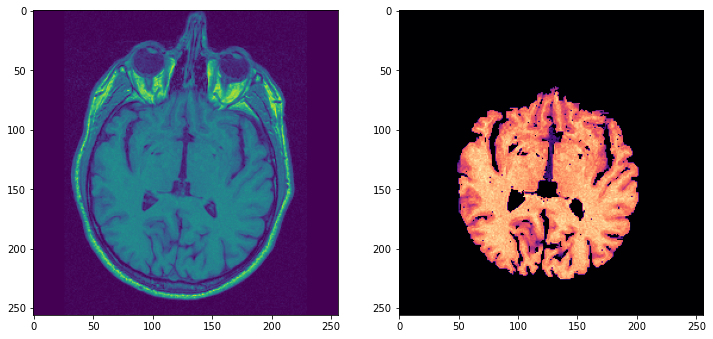

16297 pixels and it represents  24.86724853515625 % of the image


In [4]:
region_growing(brain_im,8,150,150)


### We can see that the brain is perfectly isolated. This method gives us a good estimation of the size of the brain

## 1.3 Contour detection (5pts)

### Here, we will use the contour detection method with some filters (sobel and gaussian) and a watershed 

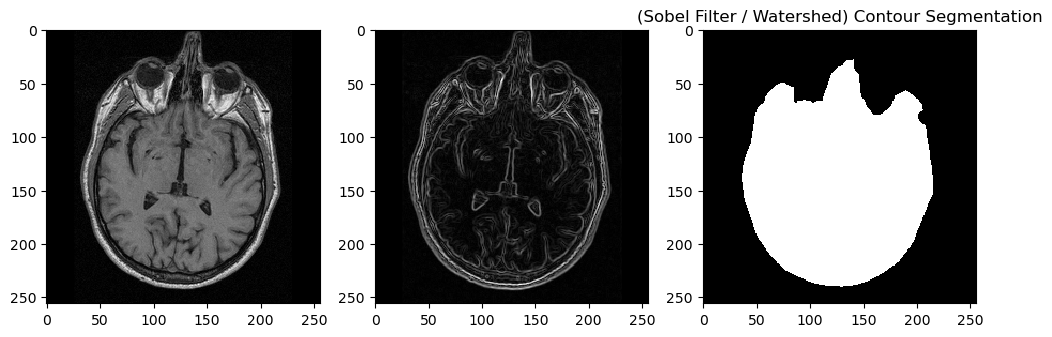

27144 pixels and it represents  41.41845703125 % of the image


In [5]:
sobel = filters.sobel(brain_im)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'    
plt.rcParams['figure.dpi'] = 100

blurred = filters.gaussian(sobel, sigma=2.72)


seed_mask = np.zeros(brain_im.shape, dtype=np.int)
seed_mask[0, 0] = 1 # background
seed_mask[70, 70] = 2 # foreground

ws = skimage.segmentation.watershed(blurred, seed_mask)

# Plots and Sizes
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(brain_im)
ax[1].imshow(sobel)
plt.title('(Sobel Filter / Watershed) Contour Segmentation')
ax[2].imshow(ws)
plt.show()

size(ws,2,1,256,256)


### This method over estimates the size of the brain

## 1.4 Additional method (5pts)

## Option 1:
### We will try to use only the thresholding to isolate the brain with the skull and then skull only in order to compute the brain size by soustraction

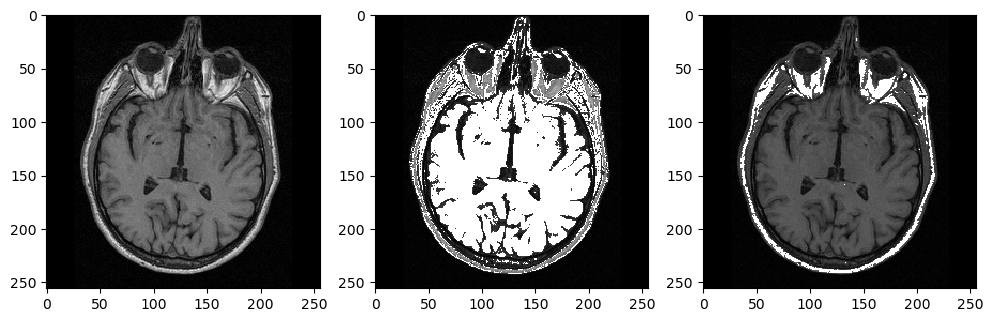

Brain + Skull: 
22011 pixels and it represents  33.58612060546875 % of the image

Skull:
2799 pixels and it represents  4.27093505859375 % of the image

Brain only:
Number of pixels of the brain is 19212 and it represents 29,33% of the image


In [6]:
brain_no_black2 = remove_black(brain_im,60,100)

brain_skull = remove_black(brain_im,100,200)

brain_skull_filtered = filters.median(brain_skull, disk(0))


# Plots and Sizes

fig, ax = plt.subplots(1, 3, figsize=(12, 10))

ax[0].imshow(brain_im)

ax[1].imshow(brain_no_black2)
ax[2].imshow(brain_skull)

plt.show()


print('Brain + Skull: ')
size(brain_no_black2,60,60,256,256)

print('')

print('Skull:')
size(brain_skull_filtered,200,200,256,256)

print('')

print('Brain only:')
print('Number of pixels of the brain is 19212 and it represents 29,33% of the image')

## Option 2: 
### In order to get a more accurate size for the brain without skull, we will first do a thresholding and then an opening:

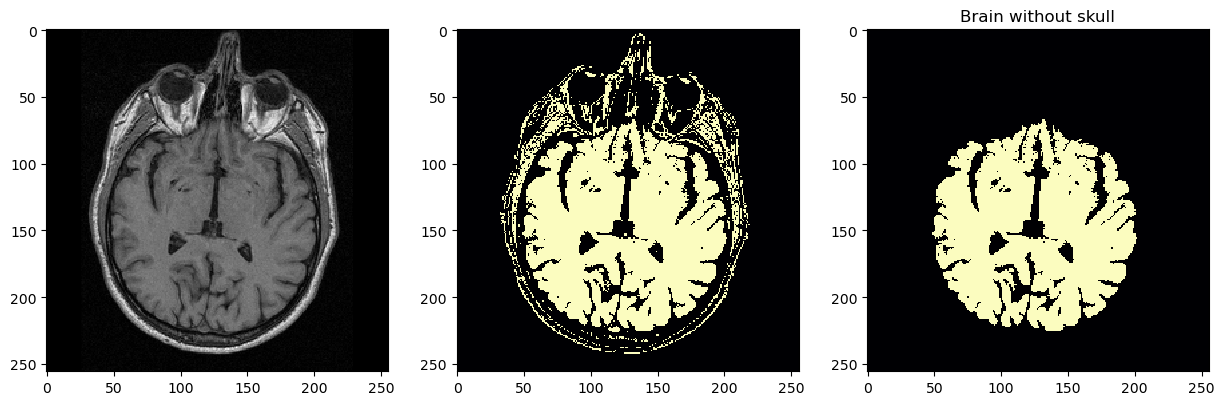

15205 pixels and it represents  23.20098876953125 % of the image


In [7]:
brain_copy=brain_im.copy()


for i in np.arange(0, im_w, 1):
    for j in np.arange(0, im_h, 1):

        if brain_copy[i][j] >= 100 :
            brain_copy[i][j]=0
            
        if brain_copy[i][j] <= 60 :
            brain_copy[i][j]=0
            
        else :
            brain_copy[i][j]=255          
            
            
opening=skimage.morphology.area_opening(brain_copy,area_threshold=1000, connectivity=1);


# Plots and Sizes
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(brain_im)
ax[1].imshow(brain_copy, cmap='magma')
ax[2].imshow(opening, cmap='magma')
plt.title('Brain without skull')
plt.show()

size(opening,100,100,256,256)

### We can see that the brain is perfectly isolated. This method gives us a good estimation of the size of the brain

## Conclusion:

### 1) Region Growing Method:      16297 pixels --> 24,8 % of the image

### 2) Contour Detection Method: 27144 pixels --> 43,3 % of the image

### 3) Thresholding Method Only:  19212 pixels --> 29,4 % of the image

### 4) Thresholding and Opening:  15205 pixels --> 23,2 % of the image

### --> The best solutions are both  the thresholding with the opening and the region growing methods

---
# Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

## 2.1 Visualization

In [8]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)

print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


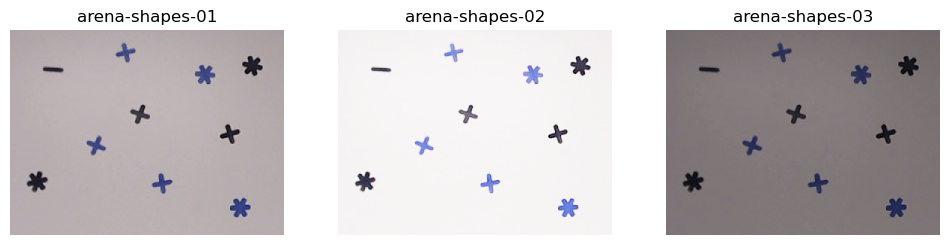

(480, 640, 3)


In [9]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))

for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

print(im.shape)


## 2.2 Number of shapes of each color (5 pts)

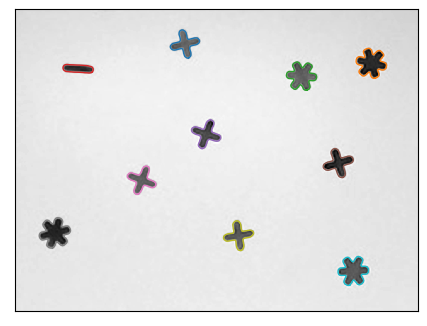

In the first image, there are 5 black patterns and 5 blue patterns


In [10]:
#Here, we find the contours of each pattern of the picture 

i=0 # For the first image 

im=skimage.color.rgb2gray(images[i])
contours0 = measure.find_contours(im,0.5)

# Display the image and plot of all contours found
fig, ax = plt.subplots()
ax.imshow(im)

for contour in contours0:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


#----------------------
#Here, we find the center of each pattern bycomputing an average on all the points of each pattern 
pattern_centers=[]

for i in range(0, len(contours0),1):
    if len(contours0[i])>20:   #This condition is to avoid the noise (outsider contour points)
        pattern_centers.append(np.average(contours0[i],axis=0))

pattern_centers=np.array(pattern_centers,int)
                        
    
#----------------------  
#Here, we find the color of each pattern
pattern_color=0
pattern_colors=[]
                           
for i in range(0, len(pattern_centers),1):
    x_local=pattern_centers[i][0]
    y_local=pattern_centers[i][1]                     
    for j in range(-2,2):
        for h in range(-2,2):
            pattern_color=pattern_color + im[j + x_local][h + y_local]
    pattern_colors.append(pattern_color)
    pattern_color=0
                       
                
#---------------------- 
#Here, we separate the pattern into two categories: blue patterns and black patterns
category1=[]
category2=[]

color_temp1=6
color_temp2=2


for j in range(0,len(pattern_colors)):
    
    if abs(pattern_colors[j]- color_temp1) < abs(pattern_colors[j]-color_temp2):
        category2.append(j)
        
    else:
        category1.append(j)
    
        
print('In the first image, there are',len(category1),'black patterns and',len(category2),'blue patterns' )

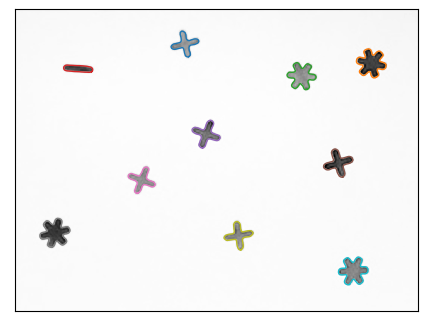

In the second image, there are 5 black patterns and 5 blue patterns


In [11]:
#Here, we find the contours of each pattern of the picture 

i=1 # For the second image 

im=skimage.color.rgb2gray(images[i])
contours0 = measure.find_contours(im,0.7)


# Display the image and plot of all contours found
fig, ax = plt.subplots()
ax.imshow(im)

for contour in contours0:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


#----------------------
#Here, we find the center of each pattern bycomputing an average on all the points of each pattern 
pattern_centers=[]

for i in range(0, len(contours0),1):
    if len(contours0[i])>20:   #This condition is to avoid the noise (outsider contour points)
        pattern_centers.append(np.average(contours0[i],axis=0))

pattern_centers=np.array(pattern_centers,int)
                        
    
#----------------------  
#Here, we find the color of each pattern
pattern_color=0
pattern_colors=[]
                           
for i in range(0, len(pattern_centers),1):
    x_local=pattern_centers[i][0]
    y_local=pattern_centers[i][1]                     
    for j in range(-2,2):
        for h in range(-2,2):
            pattern_color=pattern_color + im[j + x_local][h + y_local]
    pattern_colors.append(pattern_color)
    pattern_color=0
                       
                
#---------------------- 
#Here, we separate the pattern into two categories: blue patterns and black patterns
category1=[]
category2=[]

color_temp1=13
color_temp2=2


for j in range(0,len(pattern_colors)):
    
    if abs(pattern_colors[j]- color_temp1) < abs(pattern_colors[j]-color_temp2):
        category2.append(j)     
        
    else:
        category1.append(j)
        
        
print('In the second image, there are',len(category1),'black patterns and',len(category2),'blue patterns' )

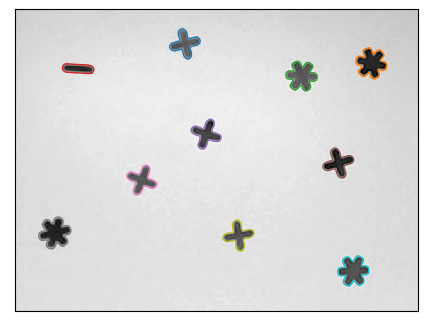

In the third image, there are 5 black patterns and 5 blue patterns


In [12]:
#Here, we find the contours of each pattern of the picture 

i=2 # For the third image 

im=skimage.color.rgb2gray(images[i])
contours0 = measure.find_contours(im,0.4)


# Display the image and plot of all contours found
fig, ax = plt.subplots()
ax.imshow(im)

for contour in contours0:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)
ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()


#----------------------
#Here, we find the center of each pattern bycomputing an average on all the points of each pattern 
pattern_centers=[]

for i in range(0, len(contours0),1):
    if len(contours0[i])>20:   #This condition is to avoid the noise (outsider contour points)
        pattern_centers.append(np.average(contours0[i],axis=0))

pattern_centers=np.array(pattern_centers,int)
                        
    
#----------------------  
#Here, we find the color of each pattern
pattern_color=0
pattern_colors=[]
                           
for i in range(0, len(pattern_centers),1):
    x_local=pattern_centers[i][0]
    y_local=pattern_centers[i][1]                     
    for j in range(-2,2):
        for h in range(-2,2):
            pattern_color=pattern_color + im[j + x_local][h + y_local]
    pattern_colors.append(pattern_color)
    pattern_color=0
                       
                
#---------------------- 
#Here, we separate the pattern into two categories: blue patterns and black patterns
category1=[]
category2=[]

color_temp1=4
color_temp2=1


for j in range(0,len(pattern_colors)):
    
    if abs(pattern_colors[j]- color_temp1) < abs(pattern_colors[j]-color_temp2):
        category2.append(j)
              
    else:
        category1.append(j)
        
print('In the third image, there are',len(category1),'black patterns and',len(category2),'blue patterns' )

### We can see that the patterns are perfectly detected and the contours are clean. This method can separate the blue patterns from the black ones. Even with different illuminations, we can separate the blue patterns from the black ones.

## 2.3 Total area (in pixels) of each color (5 pts)

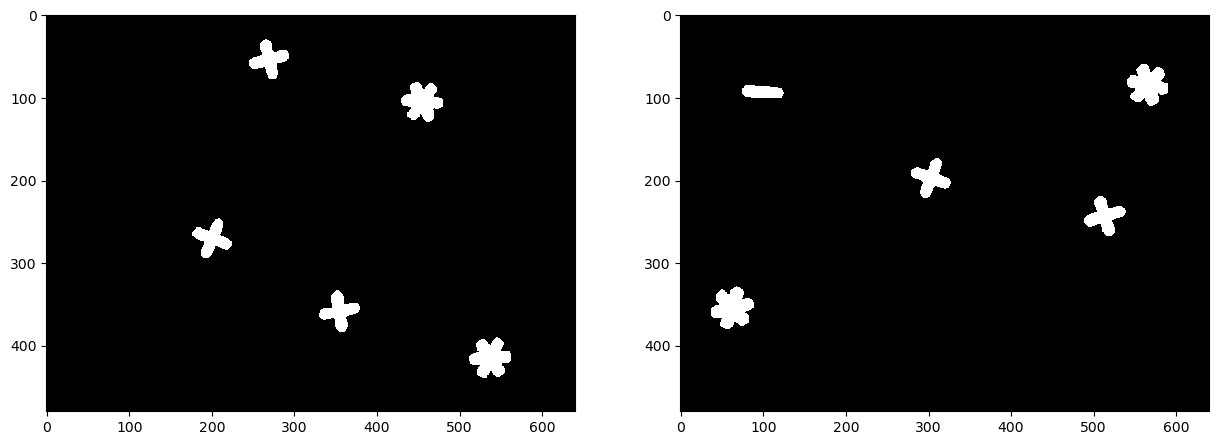

There are 6376 black pixels and 6545 blue pixels


In [13]:
# This code separate the contours between the two classes.

contours_class1 = []
contours_class2 = []

for i in category1:
    contours_class1.append(contours0[i])
    
for i in category2:
    contours_class2.append(contours0[i])
#print(contours0)

# Here we create 2 images with zeros. We then set the contours of each class to 255. We then perform and area closing 
# on both images. Finally, we count the number of pixels with a value of 255.

image_1 = np.zeros((images.shape[1], images.shape[2]))
image_2 = np.zeros((images.shape[1], images.shape[2]))


for contour in contours_class1:
    for xy in contour:
        image_1[int(xy[0])][int(xy[1])] = 255
        

for contour in contours_class2:
    for xy in contour:
        image_2[int(xy[0])][int(xy[1])] = 255
        
image_1 = skimage.morphology.area_closing(image_1, area_threshold = 10000, connectivity=1);
image_2 = skimage.morphology.area_closing(image_2, area_threshold = 10000, connectivity=1);


# Plots and Sizes
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(image_2)
ax[1].imshow(image_1)
plt.show()

counter_class1 = 0
counter_class2 = 0

for x in range(0, images.shape[1]):
    for y in range(0, images.shape[2]):
        if image_1[x][y] == 255:
            counter_class1 += 1
        
        if image_2[x][y] == 255:
            counter_class2 += 1
    
print('There are', counter_class1 ,'black pixels and', counter_class2,'blue pixels')